# Feature extraction

In [4]:
%pip install mne mne-features colorlog

Note: you may need to restart the kernel to use updated packages.


In [5]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import mne_features
import concurrent.futures
from tqdm import tqdm
from scipy import stats

import utils
logger = utils.get_logger()

In [3]:
def load_fif_file(filename):
    eeg_data = mne.read_epochs(filename)
    return eeg_data

In [68]:
rsEEG = load_fif_file("dataset-cleaned/TMS-EEG-H_02_S1b_rsEEG_pre-epo.fif")
spTEP = load_fif_file("dataset-cleaned/TMS-EEG-H_02_S1b_spTEP_post-epo.fif")

print(type(rsEEG))

<class 'mne.epochs.EpochsFIF'>


In [18]:
data = spTEP.get_data()

# average data across epochs
data = np.mean(data, axis=0)

data.shape

/tmp/ipykernel_1366995/622147417.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = spTEP.get_data()


(62, 2001)

## Label file generator

Create one file containing the labels for all files, as labels are file related and would just be duplicated in every line of the csv of the corresponding file. This save storage and keeps a structured overview and seperation of features and labels.

In [9]:
def create_labels_csv(directory, metadata_csv, output_csv, modality_mapping={'rsEEG': 0, 'spTEP': 1}, timing_mapping={'pre': 0, 'post': 1}):
    metadata = pd.read_csv(metadata_csv, index_col=0, header=None)
    data = []

    for filename in os.listdir(directory):
        # note that the s can be upper or lower case and that the letter b can be behind the session number
        match = re.match(r'TMS-EEG-(-?)H_(\d+)_(S|s)(\w+)(b?)_(rsEEG|spTEP)_(pre|post)-epo.fif', filename)
        if match:
            _, patient_id, _, session, _, eeg_type, pre_post = match.groups()
            session = int(session.rstrip('b'))
            # procedure = procedure_labels[metadata.loc[f'H{patient_id}'][session]]
            procedure = metadata.loc[f'H{patient_id}'][session]
            patient_id = int(patient_id)
            eeg_type = modality_mapping[eeg_type]
            pre_post = timing_mapping[pre_post]
            filename = filename.split(".")[0]

            data.append([filename, procedure, patient_id, eeg_type, pre_post])
            
            logger.info(f'Added entry to labels.csv: {filename}, {patient_id}, {procedure}, {eeg_type}, {pre_post}')
    print(data)
    df = pd.DataFrame(data, columns=['filename', 'procedure', 'patient', 'modality', 'timing'])
    df.to_csv(output_csv, index=False, sep=",")
    
create_labels_csv("dataset-cleaned", "Randomisatielijst.csv", "labels.csv")

[2024-06-20 15:41:42,827] - INFO - Added entry to labels.csv: TMS-EEG-H_06_S3_spTEP_post-epo, 6, 0, 1, 1
[2024-06-20 15:41:42,828] - INFO - Added entry to labels.csv: TMS-EEG-H_14_S2_rsEEG_post-epo, 14, 2, 0, 1
[2024-06-20 15:41:42,830] - INFO - Added entry to labels.csv: TMS-EEG-H_15_S1_spTEP_pre-epo, 15, 1, 1, 0
[2024-06-20 15:41:42,831] - INFO - Added entry to labels.csv: TMS-EEG-H_08_S2_rsEEG_pre-epo, 8, 2, 0, 0
[2024-06-20 15:41:42,832] - INFO - Added entry to labels.csv: TMS-EEG-H_16_S2_spTEP_pre-epo, 16, 0, 1, 0
[2024-06-20 15:41:42,833] - INFO - Added entry to labels.csv: TMS-EEG-H_17_S3_spTEP_pre-epo, 17, 1, 1, 0
[2024-06-20 15:41:42,834] - INFO - Added entry to labels.csv: TMS-EEG-H_09_S3_rsEEG_pre-epo, 9, 0, 0, 0
[2024-06-20 15:41:42,835] - INFO - Added entry to labels.csv: TMS-EEG-H_13_S3_rsEEG_pre-epo, 13, 0, 0, 0
[2024-06-20 15:41:42,836] - INFO - Added entry to labels.csv: TMS-EEG-H_12_S2_rsEEG_pre-epo, 12, 1, 0, 0
[2024-06-20 15:41:42,837] - INFO - Added entry to labels

[['TMS-EEG-H_06_S3_spTEP_post-epo', 0, 6, 1, 1], ['TMS-EEG-H_14_S2_rsEEG_post-epo', 2, 14, 0, 1], ['TMS-EEG-H_15_S1_spTEP_pre-epo', 1, 15, 1, 0], ['TMS-EEG-H_08_S2_rsEEG_pre-epo', 2, 8, 0, 0], ['TMS-EEG-H_16_S2_spTEP_pre-epo', 0, 16, 1, 0], ['TMS-EEG-H_17_S3_spTEP_pre-epo', 1, 17, 1, 0], ['TMS-EEG-H_09_S3_rsEEG_pre-epo', 0, 9, 0, 0], ['TMS-EEG-H_13_S3_rsEEG_pre-epo', 0, 13, 0, 0], ['TMS-EEG-H_12_S2_rsEEG_pre-epo', 1, 12, 0, 0], ['TMS-EEG-H_11_S1_rsEEG_pre-epo', 2, 11, 0, 0], ['TMS-EEG-H_07_S1_spTEP_post-epo', 0, 7, 1, 1], ['TMS-EEG-H_06_S3_spTEP_pre-epo', 0, 6, 1, 0], ['TMS-EEG-H_18_S3_rsEEG_pre-epo', 2, 18, 0, 0], ['TMS-EEG-H_07_S2_spTEP_pre-epo', 1, 7, 1, 0], ['TMS-EEG-H_02_S3_rsEEG_pre-epo', 1, 2, 0, 0], ['TMS-EEG-H_12_S2_rsEEG_post-epo', 1, 12, 0, 1], ['TMS-EEG-H_13_S2_spTEP_post-epo', 2, 13, 1, 1], ['TMS-EEG-H_08_s1_rsEEG_pre-epo', 0, 8, 0, 0], ['TMS-EEG-H_06_S1_rsEEG_post-epo', 1, 6, 0, 1], ['TMS-EEG-H_18_S2_rsEEG_post-epo', 1, 18, 0, 1], ['TMS-EEG-H_15_S2_spTEP_post-epo', 0, 15,

## Using `mne_features` library

In [ ]:
# Open fif file
def load_fif_file(filename):
    eeg_data = mne.read_epochs(filename)
    return eeg_data

# Extract features from epochs file
def get_features(epochs):
    """Extract features from epochs, returns a dictionary mapping feature names to values."""
    return {"mean": 2}

# Save features to csv file
def save_features(features, filename):
    """Save features to a csv file from a dataframe."""
    pd.DataFrame.to_csv()
    pass

In [92]:
# List of features to extract
# mean is useless because of the rereferencing to the average
# takes long to calculate: app entropy
selected_funcs = [
    "variance",
    "std",
    "ptp_amp",
    "skewness",
    "kurtosis",
    "rms",
    "hjorth_mobility",
    "hjorth_complexity",
    "zero_crossings",
    # "line_length", # tentative
    "app_entropy",  # tentative
    "spect_entropy", # tentative
    "hurst_exp",  # tentative
    # ==============
    "pow_freq_bands",
    "wavelet_coef_energy",
    # "spect_slope", # tentative
    # ==============
    "phase_lock_val",
    "time_corr",
    "spect_corr",
    # ==============
]

def feature_df(rseeg, sptep, rseeg_funcs, filename=None, n_jobs=2, save=True):
    filename = filename.split(".")[0] + ".csv"
    rseeg_df = mne_features.feature_extraction.extract_features(rseeg.get_data(copy=True), selected_funcs=rseeg_funcs, n_jobs=n_jobs, return_as_df=True, sfreq=rseeg.info["sfreq"], ch_names=rseeg.ch_names) # shape (num_epochs, num_features * num_channels)
    # sptep_df = compute_tep(sptep)
    # sptep_df = pd.concat([sptep_df]*len(rseeg_df), ignore_index=True)
    # feature_df = pd.concat([rseeg_df, sptep_df], axis=1)

    if save and filename is not None:
        rseeg_df.to_csv(filename, index=False)
    
    return rseeg_df

# Process file pairs
def process_file(filename_template, source_folder, destination_folder=None):
    #filename template without file extension
    logger.info(f'Processing file pair {filename_template}')
    rseeg = load_fif_file(os.path.join(source_folder, filename_template.format(modality="rsEEG")))
    sptep = load_fif_file(os.path.join(source_folder, filename_template.format(modality="spTEP")))
    # destination_filename = filename_template.format(modality="").rstrip("_")
    df = feature_df(rseeg, sptep, selected_funcs, filename=os.path.join(destination_folder, filename_template.format(modality="rsEEG")), save=True)
    logger.info(df)

def feat_extr_on_folder(source_folder, destination_folder, parallel=True):
    # Make sure the destination folder for csv files exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get file pairs
    session_templates = set()
    pattern = re.compile(r'(spTEP|rsEEG)')
    files = os.listdir(source_folder)
    for filename in files:
        if pattern.search(filename):
            session_templates.add(pattern.sub('{modality}', filename))
    
    if parallel:
        with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
                futures = [executor.submit(process_file, file, source_folder, destination_folder) for file in files]
                for f in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
                    pass
    else:
        for file in session_templates:
            process_file(file, source_folder, destination_folder)

feat_extr_on_folder("dataset-cleaned", "features", parallel=False)

[2024-06-18 13:47:20,410] - INFO - Processing file pair TMS-EEG-H_02_S1b_{modality}_pre-epo.fif
[2024-06-18 13:50:54,682] - INFO -          variance                                                          \
               Iz            O2            Oz            O1           PO8   
0    5.100870e-11  4.151750e-11  3.490771e-11  3.337430e-11  4.999330e-11   
1    5.813249e-11  6.254035e-11  4.805375e-11  4.753103e-11  7.205062e-11   
2    2.859427e-11  4.464964e-11  2.477198e-11  2.754028e-11  5.038374e-11   
3    3.219749e-11  3.237344e-11  2.401229e-11  2.224999e-11  3.405083e-11   
4    4.045021e-11  4.148137e-11  3.180912e-11  2.657199e-11  4.166491e-11   
..            ...           ...           ...           ...           ...   
312  6.459162e-11  5.897869e-11  5.240706e-11  5.547596e-11  7.274785e-11   
313  9.519563e-11  1.010768e-10  8.840140e-11  9.755105e-11  1.104553e-10   
314  1.164130e-10  1.090147e-10  1.013230e-10  1.210561e-10  1.109526e-10   
315  1.673056e-10  1.4

# TEP features
* TEP amplitudes and latencies
* AUC
* Peak-to-peak amplitude

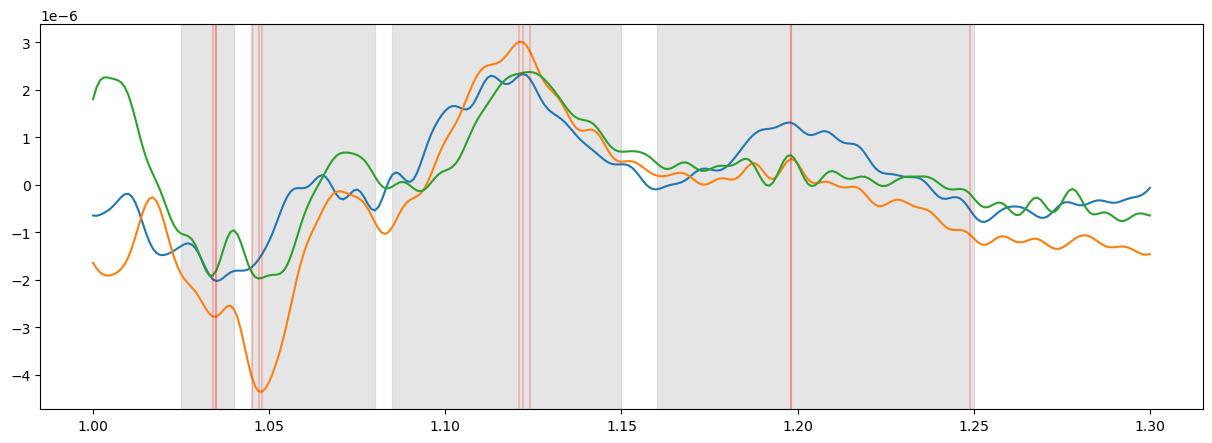

In [86]:
# tep windows by tautan 2023

def compute_tep(epochs, tep_windows=[(25, 40), (45, 80), (85, 150), (160, 250)]):
    """Returns the DataFrame with latencies and amplitudes for each TEP window and channel."""
    evoked = epochs.average().crop(tmin=1.0)
    sfreq = evoked.info["sfreq"]
    channel_names = evoked.info["ch_names"]
    
    latency_data = []
    amplitude_data = []
    headers = []
    
    # Calculate values with respective header names
    for start, end in tep_windows:
        for i, channel in enumerate(channel_names):
            window = evoked.data[channel_names.index(channel), int(start/1000 * sfreq):int(end/1000 * sfreq)]
            max_index = np.argmax(np.abs(window))
            
            if end <= 80:
                window_start = max(max_index - 5, 0)
                window_end = min(max_index + 5 + 1, len(window))
            else:
                window_start = max(max_index - 15, 0)
                window_end = min(max_index + 15 + 1, len(window))

            average_value = np.mean(window[window_start:window_end])
            latency = max_index / sfreq * 1000 + start
            
            latency_data.append(latency)
            amplitude_data.append(average_value)
            headers.append(f"ch{i}_{start}-{end}")
    
    # Prepare the MultiIndex for columns
    num_channels = len(channel_names)
    num_windows = len(tep_windows)
    first_level = ['TEP latency'] * num_channels * num_windows + ['TEP amplitude'] * num_channels * num_windows
    second_level = headers * 2  # Duplicate headers for both latency and amplitude
    columns = pd.MultiIndex.from_arrays([first_level, second_level])

    combined_data = latency_data + amplitude_data
    reshaped_data = np.array(combined_data).reshape(1, -1)
    
    df = pd.DataFrame(reshaped_data, columns=columns)
    # repeat for all epochs
    df = pd.concat([df], ignore_index=True)
    
    return df

compute_tep(spTEP)

# display latencies on a plot with the waveform
def plot_tep(epochs, tep_windows=[(25, 40), (45, 80), (85, 150), (160, 250)]):
    epochs = epochs.copy().pick(["Cz", "C1", "C3"])
    tep_data = compute_tep(epochs, tep_windows)
    evoked = epochs.average().crop(tmin=1.0, tmax=1.3)
    sfreq = evoked.info["sfreq"]
    channel_names = evoked.info["ch_names"]
    
    # plot evoked data with numpy
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    for i, channel in enumerate(channel_names):
        ax.plot(evoked.times, evoked.data[i], label=channel)
    
    # plot window zones
    for start, end in tep_windows:
        ax.axvspan((start + 1000) / 1000, (end + 1000) / 1000, alpha=0.2, color='gray')
    
    # get latency for each window for each channel
    for i, (start, end) in enumerate(tep_windows):
        latencies = tep_data.iloc[0, i * len(channel_names): (i + 1) * len(channel_names)]
        for latency in latencies:
            ax.axvline((latency + 1000) / 1000, color='r', linestyle='-', alpha=0.2)
        # ax.axvline(average_latency / 1000, color='r', linestyle='--', label=f"Average TEP latency {start}-{end}")
    # ax.legend()
    plt.show()

plot_tep(spTEP)

In [6]:
def compute_tep_from_np(epochs, sfreq=1000, ch_names=[], tep_windows=[(25, 40), (45, 80), (85, 150), (160, 250)]):
    """Returns the DataFrame with latencies and amplitudes for each TEP window and channel."""
    logger.info(f"epochs shape: {epochs.shape}")
    evoked = np.mean(epochs, axis=0)
    
    latency_data = []
    amplitude_data = []
    headers = []
    
    # Calculate values with respective header names
    for start, end in tep_windows:
        for i, channel in enumerate(ch_names):
            window = evoked.data[ch_names.index(channel), int(start/1000 * sfreq):int(end/1000 * sfreq)]
            max_index = np.argmax(np.abs(window))
            
            if end <= 80:
                window_start = max(max_index - 5, 0)
                window_end = min(max_index + 5 + 1, len(window))
            else:
                window_start = max(max_index - 15, 0)
                window_end = min(max_index + 15 + 1, len(window))

            average_value = np.mean(window[window_start:window_end])
            latency = max_index / sfreq * 1000 + start
            
            latency_data.append(latency)
            amplitude_data.append(average_value)
            headers.append(f"ch{i}_{start}-{end}")
    
    # Prepare the MultiIndex for columns
    num_channels = len(ch_names)
    num_windows = len(tep_windows)
    first_level = ['TEP latency'] * num_channels * num_windows + ['TEP amplitude'] * num_channels * num_windows
    second_level = headers * 2  # Duplicate headers for both latency and amplitude
    columns = pd.MultiIndex.from_arrays([first_level, second_level])

    combined_data = latency_data + amplitude_data
    reshaped_data = np.array(combined_data).reshape(1, -1)
    
    df = pd.DataFrame(reshaped_data, columns=columns)
    # repeat for all epochs
    df = pd.concat([df] * len(epochs), ignore_index=True)
    
    return df

compute_tep_from_np(spTEP.get_data())

/tmp/ipykernel_1366995/116475260.py:48: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  compute_tep_from_np(spTEP.get_data())
[2024-06-17 18:49:32,897] - INFO - epochs shape: (149, 62, 2001)


AttributeError: 'numpy.ndarray' object has no attribute 'average'

In [85]:
df = mne_features.feature_extraction.extract_features(spTEP.get_data(copy=True), sfreq=rsEEG.info["sfreq"], selected_funcs=["pow_freq_bands"], n_jobs=2, return_as_df=True) # shape (num_epochs, num_features * num_channels)
df

pow_freq_bands                                                    \
         ch0_band0 ch0_band1 ch0_band2 ch0_band3 ch0_band4 ch1_band0   
0         0.196254  0.197452  0.139015  0.077041  0.277194  0.168963   
1         0.586481  0.150974  0.048623  0.043014  0.082636  0.563683   
2         0.192994  0.117736  0.115533  0.124617  0.374359  0.263144   
3         0.338312  0.122151  0.137414  0.106216  0.178257  0.248235   
4         0.420793  0.110751  0.080816  0.094705  0.153966  0.426137   
..             ...       ...       ...       ...       ...       ...   
144       0.214528  0.112122  0.108099  0.125076  0.367748  0.260820   
145       0.252121  0.155489  0.093521  0.118876  0.301301  0.250688   
146       0.422483  0.067173  0.025504  0.059304  0.229234  0.419837   
147       0.211764  0.130022  0.046525  0.148525  0.377487  0.242930   
148       0.251124  0.160131  0.119771  0.143789  0.214604  0.263123   

                                             ...                        \
    ch1_band1 ch1_band2 ch1_band3 ch1_band4  ... ch60_band0 ch60_band1   
0    0.256945  0.205731  0.145822  0.175700  ...   0.273865   0.253694   
1    0.187385  0.066222  0.051962  0.055184  ...   0.715827   0.145851   
2    0.221373  0.105445  0.134116  0.208862  ...   0.298045   0.162521   
3    0.142622  0.205507  0.175668  0.144991  ...   0.827116   0.030047   
4    0.122111  0.113016  0.122682  0.085391  ...   0.622342   0.115822   
..        ...       ...       ...       ...  ...        ...        ...   
144  0.184818  0.135998  0.197857  0.150505  ...   0.204656   0.240809   
145  0.256311  0.216338  0.161895  0.089802  ...   0.263764   0.149851   
146  0.104341  0.040145  0.126870  0.157477  ...   0.629753   0.022763   
147  0.176199  0.110129  0.199838  0.209124  ...   0.236167   0.124439   
148  0.179975  0.151540  0.199602  0.129331  ...   0.556410   0.138480   

                                                                       \
    ch60_band2 ch60_band3 ch60_band4 ch61_band0 ch61_band1 ch61_band2   
0     0.086186   0.142431   0.196348   0.267230   0.201962   0.068241   
1     0.014598   0.006033   0.005449   0.715259   0.143231   0.014282   
2     0.114153   0.171109   0.186898   0.323379   0.127663   0.100351   
3     0.019838   0.011613   0.013492   0.833868   0.043682   0.012031   
4     0.006026   0.006339   0.008316   0.622503   0.112227   0.005345   
..         ...        ...        ...        ...        ...        ...   
144   0.167862   0.124110   0.202485   0.128247   0.213904   0.184460   
145   0.144955   0.149536   0.219164   0.263350   0.095166   0.097965   
146   0.014644   0.015807   0.018339   0.622040   0.018641   0.015189   
147   0.084464   0.216936   0.272524   0.267454   0.099921   0.046730   
148   0.044485   0.035972   0.040119   0.637923   0.064375   0.026720   

                           
    ch61_band3 ch61_band4  
0     0.160142   0.265380  
1     0.006751   0.005072  
2     0.162993   0.231979  
3     0.006357   0.012442  
4     0.005372   0.008100  
..         ...        ...  
144   0.169043   0.254433  
145   0.160854   0.318074  
146   0.016766   0.023627  
147   0.182511   0.322466  
148   0.022318   0.040644  

[149 rows x 310 columns]

# Scrap
## rsEEG

## Statistical features
- Mean
- STD
- Peak amplitude

In [ ]:
def mean_dict(eeg_data):
    data = eeg_data.get_data()
    ch_names = eeg_data.info['ch_names']
    avg_values = np.mean(data, axis=1)
    electrode_avg_dict = dict(zip(ch_names, avg_values))
    return electrode_avg_dict

def total_mean(mean_dict, electrodes=None):
    if electrodes is None:
        return np.mean(list(mean_dict.values()))
    else:
        return np.mean([mean_dict[electrode] for electrode in electrodes])
    
def std_dict(eeg_data):
    data = eeg_data.get_data()
    ch_names = eeg_data.info['ch_names']
    std_values = np.std(data, axis=1)
    electrode_std_dict = dict(zip(ch_names, std_values))
    return electrode_std_dict

def total_std(std_dict, electrodes=None):
    if electrodes is None:
        return np.mean(list(std_dict.values()))
    else:
        return np.mean([std_dict[electrode] for electrode in electrodes])
    
def peak_dict(eeg_data):
    data = eeg_data.get_data()
    ch_names = eeg_data.info['ch_names']
    peak_values = np.max(data, axis=1)
    electrode_peak_dict = dict(zip(ch_names, peak_values))
    return electrode_peak_dict

In [ ]:
print("Mean dict: ", mean_dict(rsEEG))
print("Total mean: ", total_mean(mean_dict(rsEEG)))
print("STD dict: ", std_dict(rsEEG))
print("Total STD: ", total_std(std_dict(rsEEG)))

## Power spectrum

In [ ]:
rsEEG.compute_psd(fmin=0.5, fmax=100, n_fft=2048, n_overlap=1024, verbose=True).plot()